<a href="https://colab.research.google.com/github/fmhirwa/alu-MLI_Summative/blob/main/Chatbot_ALU_admissions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ALU Admissions CHatbot**

Steps
1. Tokenization
2. Fine tuning GPT 2 From OpenAI
3. Evaluation against Eval
4. UI with Gradio

1. Tokenization + Preprocessing

In [42]:
# Import necessary classes from tokenizers and transformers
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from transformers import PreTrainedTokenizerFast

# Step 1: Initialize the tokenizer with the BPE model and specify the unknown token
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))

# Step 2: Create a trainer with special tokens you want to include
trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

# Step 3: Set the pre-tokenizer to split text by whitespace
tokenizer.pre_tokenizer = Whitespace()

# Step 4: Define the list of file paths that the tokenizer will be trained on.
files = ["data/file1.txt", "data/ALU_train2.txt", "data/ALU_val3.txt"]

# Step 5: Train the tokenizer on the specified files using the trainer
tokenizer.train(files, trainer)

# The trained tokenizer to a JSON file for future re-use
tokenizer.save("tokenizer.json")

# Step 6: Load the trained tokenizer into the Transformers library as a fast tokenizer
# Directly from the tokenizer object
fast_tokenizer = PreTrainedTokenizerFast(tokenizer_object=tokenizer)

# Alternatively, load from the saved JSON file (uncomment the next line if needed)
# fast_tokenizer = PreTrainedTokenizerFast(tokenizer_file="tokenizer.json")

# Encode some sample text using the fast tokenizer
sample_text = "Welcome to African Leadership University."
encoded = fast_tokenizer.encode(sample_text)

# Print the encoded token IDs directly (encoded is a list of token IDs)
print("Encoded IDs:", encoded)


encoded_plus = fast_tokenizer.encode_plus(
    sample_text,
    add_special_tokens=True,
)
print("Encoded IDs using encode_plus:", encoded_plus["input_ids"])

# Print the tokenized output (tokens as strings)
print("Tokenized Output:", fast_tokenizer.tokenize(sample_text))


Encoded IDs: [47, 314, 137, 56, 126, 436, 243, 577, 12]
Encoded IDs using encode_plus: [47, 314, 137, 56, 126, 436, 243, 577, 12]
Tokenized Output: ['W', 'el', 'com', 'e', 'to', 'African', 'Leadership', 'University', '.']


2. Fine-tuning GPT2

In [52]:
import os
from transformers import (
    GPT2LMHeadModel,
    GPT2TokenizerFast,
    TextDataset,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments
)

# Define function to load a text dataset for language modeling
def load_dataset(file_path, tokenizer, block_size=128):
    return TextDataset(
        tokenizer=tokenizer,
        file_path=file_path,
        block_size=block_size,
        overwrite_cache=True
    )

# Paths to training and validation text files
train_file = "./data/ALU_train2.txt"  # Contains ALU info & conversational pairs
val_file = "./data/ALU_val3.txt"

# Load the pre-trained GPT-2 model and tokenizer
model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2TokenizerFast.from_pretrained(model_name)

# Use custom tokenizer from token_code.py
#from transformers import PreTrainedTokenizerFast
#okenizer = PreTrainedTokenizerFast(tokenizer_file="tokenizer.json")

# Create datasets
train_dataset = load_dataset(train_file, tokenizer, block_size=128)
val_dataset = load_dataset(val_file, tokenizer, block_size=128) if os.path.exists(val_file) else None

# Create a data collator for language modeling (no masking for GPT-2)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Define training hyperparameters using TrainingArguments
training_args = TrainingArguments(
    output_dir="./gpt2-finetuned-alu",
    overwrite_output_dir=True,
    num_train_epochs= 50,                  # number of epochs
    per_device_train_batch_size=2,       # batch size based on hardware
    per_device_eval_batch_size=2,
    evaluation_strategy="steps" if val_dataset else "no",
    eval_steps=500,                      # Evaluation frequency
    logging_steps=100,
    save_steps=500,
    learning_rate=5e-5,
    weight_decay=0.01,
    report_to="none",                    # Set to "tensorboard" or "wandb" if desired
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Start fine-tuning the model
trainer.train()

# Save the fine-tuned model and tokenizer for later use
model.save_pretrained("./gpt2-finetuned-alu")
tokenizer.save_pretrained("./gpt2-finetuned-alu")


/usr/local/lib/python3.11/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1250 > 1024). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss


('./gpt2-finetuned-alu/tokenizer_config.json',
 './gpt2-finetuned-alu/special_tokens_map.json',
 './gpt2-finetuned-alu/vocab.json',
 './gpt2-finetuned-alu/merges.txt',
 './gpt2-finetuned-alu/added_tokens.json',
 './gpt2-finetuned-alu/tokenizer.json')

3. Evaluation

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


Prompt: What is African Leadership University (ALU)?
Reference: ALU is committed to transforming higher education in Africa by developing ethical and entrepreneurial leaders. It has campuses in Rwanda and Mauritius and offers a unique learning experience focused on real-world problem-solving and leadership development.
Generated: ALU is committed to transforming higher education in Africa by developing ethical and entrepreneurial leaders. It has campuses in Rwanda and Mauritius and offers a unique learning experience focused on real-world problem-solving, leadership development, and community engagement.
BLEU: 0.8439, F1: 0.8056
--------------------------------------------------
Prompt: What is the BSc (Hons) International Business and Trade program about?
Reference: It prepares leaders to navigate global business complexities and drive Africa’s economic integration, covering topics like international trade, regional integration, and global supply chain management.
Generated: It prepar

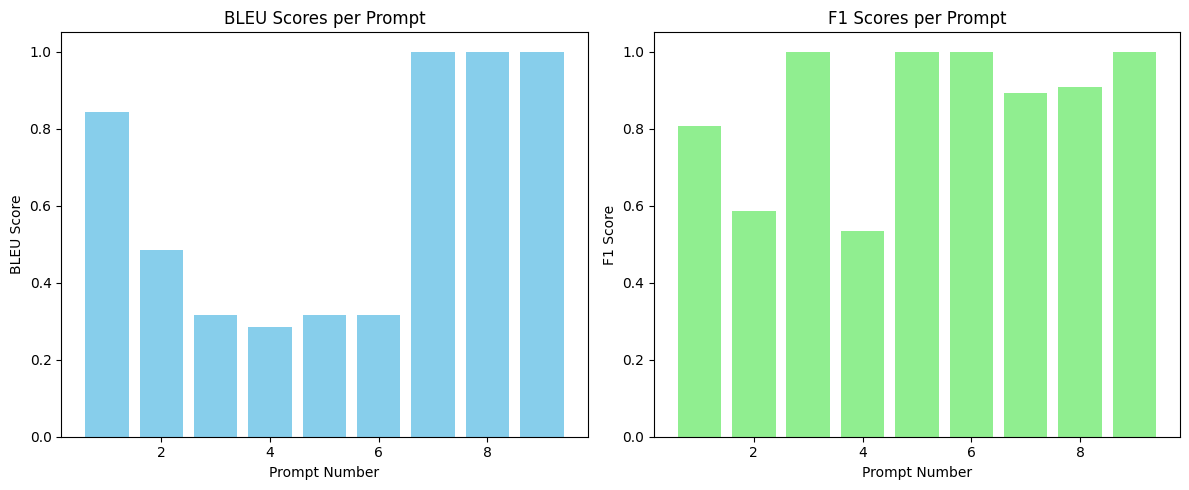

Average BLEU Score: 0.6179
Average F1 Score: 0.8588


In [60]:
import os
import re
import torch
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Load fine-tuned GPT-2 model and tokenizer using consistent classes
model_dir = "./gpt2-finetuned-alu"
model = GPT2LMHeadModel.from_pretrained(model_dir)
tokenizer = PreTrainedTokenizerFast.from_pretrained(model_dir)
model.eval()

def compute_f1(prediction, reference):
    pred_tokens = prediction.split()
    ref_tokens = reference.split()
    common = set(pred_tokens) & set(ref_tokens)
    if not common:
        return 0.0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(ref_tokens)
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

# Load evaluation prompts and references
with open("./data/ALU_val2.txt", "r", encoding="utf-8") as f:
    eval_data = f.read()

pattern = r"\[Prompt \d+\]\s*Q:\s*(.*?)\s*A:\s*(.*?)\s*(?=\[Prompt \d+\]|$)"
matches = re.findall(pattern, eval_data, re.DOTALL)
prompts, references = zip(*[(m[0].strip(), m[1].strip()) for m in matches])

# Evaluate each prompt
bleu_scores, f1_scores, generated_responses = [], [], []
for prompt, ref in zip(prompts, references):
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    attention_mask = torch.ones_like(input_ids)  # attention_mask added
    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_length=100,                  # Reduced length for concise answers
            num_beams=7,                     # Increased beams for better quality
            no_repeat_ngram_size=3,          # Higher ngram for reduced repetition
            temperature=0.7,                 # More controlled generation
            top_p=0.9,                       # Nucleus sampling
            early_stopping=True,
            pad_token_id=tokenizer.eos_token_id
        )
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    # Remove the prompt if it is repeated
    if generated_text.startswith(prompt):
        generated_text = generated_text[len(prompt):].strip()
    # Limit the generated answer to just one line:
    generated_text = generated_text.split("\n")[0].strip()
    generated_responses.append(generated_text)

    smoothing_fn = SmoothingFunction().method1
    bleu = sentence_bleu([ref.split()], generated_text.split(), smoothing_function=smoothing_fn)
    f1 = compute_f1(generated_text, ref)
    bleu_scores.append(bleu)
    f1_scores.append(f1)

    print(f"Prompt: {prompt}\nReference: {ref}\nGenerated: {generated_text}\nBLEU: {bleu:.4f}, F1: {f1:.4f}\n" + "-"*50)

# Plot BLEU and F1 scores
x = range(1, len(prompts) + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(x, bleu_scores, color='skyblue')
plt.xlabel("Prompt Number")
plt.ylabel("BLEU Score")
plt.title("BLEU Scores per Prompt")

plt.subplot(1, 2, 2)
plt.bar(x, f1_scores, color='lightgreen')
plt.xlabel("Prompt Number")
plt.ylabel("F1 Score")
plt.title("F1 Scores per Prompt")

plt.tight_layout()
plt.show()

# Summary Metrics
print(f"Average BLEU Score: {sum(bleu_scores)/len(bleu_scores):.4f}")
print(f"Average F1 Score: {sum(f1_scores)/len(f1_scores):.4f}")


In [45]:
!pip install -q gradio

In [61]:
import gradio as gr
import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

# Load the fine-tuned GPT-2 model and tokenizer
model_dir = "./gpt2-finetuned-alu"
model = GPT2LMHeadModel.from_pretrained(model_dir)
tokenizer = GPT2TokenizerFast.from_pretrained(model_dir)
model.eval()

# Generation function
def generate_response(message, history):
    """
    Generate a response from GPT-2 based on user input and chat history,
    and limit the answer to one line.
    """
    # Combine previous history into context
    context = ""
    for user_msg, bot_msg in history:
        context += f"User: {user_msg}\nAI: {bot_msg}\n"
    context += f"User: {message}\nAI:"

    # Encode the context
    input_ids = tokenizer.encode(context, return_tensors="pt", max_length=1024, truncation=True)
    attention_mask = torch.ones_like(input_ids)  # Attention mask

    # Generate response
    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_length=150,
            num_beams=5,
            no_repeat_ngram_size=2,
            early_stopping=True,
            pad_token_id=tokenizer.eos_token_id
        )
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Extract the AI's new response from the generated text
    response = generated_text.split("AI:")[-1].strip()
    # Limit the answer to just one line: take the text before the first newline
    response = response.split("\n")[0].strip()

    # Append the new exchange to history
    history.append((message, response))
    return history, history

# 💬 Gradio Chatbot Interface
with gr.Blocks(css="""
    .chatbox {display: flex; flex-direction: column; height: 600px; overflow-y: auto; padding: 10px; background-color: #f9f9f9; border-radius: 10px;}
    .message {max-width: 70%; padding: 10px; margin-bottom: 10px; border-radius: 10px; line-height: 1.5;}
    .user {align-self: flex-start; background-color: #d1e7dd; color: #0f5132;}
    .ai {align-self: flex-end; background-color: #cfe2ff; color: #084298;}
""") as iface:
    gr.Markdown("# 🤖 **ALU Chatbot**\nAsk me anything about African Leadership University — Admissions, Programs, or Financial Aid!")

    chatbot = gr.Chatbot(label="Chat History", elem_id="chatbot", height=500)

    with gr.Row():
        user_input = gr.Textbox(
            show_label=False,
            placeholder="How can I help?",
            lines=1,
            scale=10
        )
        send_button = gr.Button("Send", scale=1)

    # State to store conversation history
    state = gr.State([])

    # Submit interaction
    user_input.submit(generate_response, [user_input, state], [chatbot, state])
    send_button.click(generate_response, [user_input, state], [chatbot, state])

# Launch with a shareable link
iface.launch(share=True)


/usr/local/lib/python3.11/dist-packages/gradio/components/chatbot.py:285: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bae2a8b43caba35351.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
